# Metabatt Simulation Environment
This notebook contains examples on how to run the metabatt environment.
Code: https://gitlab.com/Feltbo/metabatt

## 1. Building a graph from scratch using the Environment
As a first example, we will use the environment to create a graph by hand.

In [1]:
import os
import sys
sys.path.append('..')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


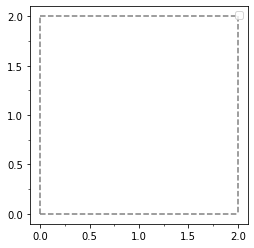

In [2]:
from metabatt.graph import Graph, Edge, Subgraphs

# start by making an empty unit cell
graph = Graph(n_cells_w=3,  # dimension width
              n_cells_h=3,  # dimension height
              max_edge_length=1.5, # reduces computational time if known
              pbc=[True, True]) # apply periodic boundary conditions
graph.plot()

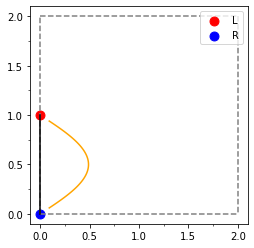

In [3]:
graph.add_node(node_id=0, position=[0.0,0.0])
graph.add_node(node_id=1, position=[0.0,1.0])
edge = Edge(graph.get_node(0), graph.get_node(1), graph)
graph.add_edge(edge)
graph.assign_rotation_to_nodes()  # rotation direction needs to be known, can also be set by hand
graph.bend_edges()
graph.plot()



angles=[0, 30, 60, 90]
lengths=[1]
#subgraph = Subgraphs(angles, lengths, node=graph.get_node(0)).graphs[0]
#graph.add_subgraph_to_node(graph.get_node(0), subgraph)
#graph.plot()

Lets start by making a graph from scratch and then move to using subgraphs that build up the graph subsequently.

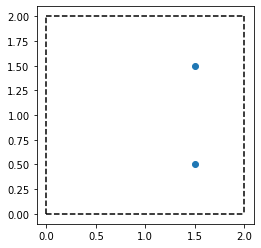

In [5]:
# add nodes to the graph
graph.add_node(node_id=0, position=[1.5, 1.5])
graph.add_node(node_id=1, position=[1.5, 0.5])
graph.plot()

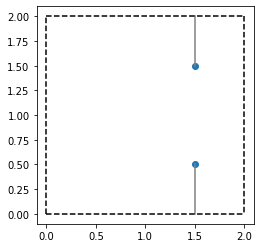

In [6]:
# add and edge to the graph
edge = Edge(graph.get_node(0), graph.get_node(1), graph)
graph.add_edge(edge)
graph.plot()

Note that the vector is now assigned randomly, since in principle you could also connect the nodes in a different ways due to the periodic boundary conditions. For this to work, you can provide the vector directly to the Edge.

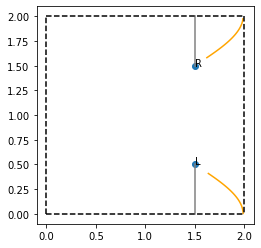

In [7]:
# now lets also add a bended edge to the graph
graph.assign_rotation_to_nodes()  # rotation direction needs to be known, can also be set by hand
graph.bend_edges()
graph.plot()

## 1.1. Adding Subgraphs to a graph
After adding nodes and edges by hand, we now move to adding a full subgraph to the current graph. Currently only two nodes and one edges are implemented in the Subgraph class, but in principle any kind of subgraph can be added.

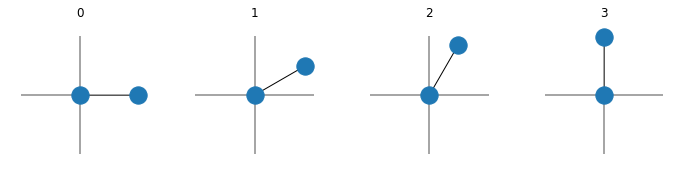

In [4]:
# start by creating a set of subgraphs
angles=[0, 30, 60, 90]
lengths=[1]
subgraphs = Subgraphs(angles, lengths)
subgraphs.visualize()

In [5]:
# now lets add one of these subgraphs to a node
# Note that currently each time a new Subgraph instance is created for every node
# since the positions need to be recalculated
subgraph = Subgraphs(angles, lengths, node=graph.get_node(0)).graphs[0]
graph.add_subgraph_to_node(graph.get_node(0), subgraph)
graph.plot()

AssertionError: 

What just happened is that adding a subgraph to the graph combines all of the steps above including
* adding nodes to graph
* adding edges to the graph
* assigning rotation directions to the nodes
* bending the edges of the added subgraph

## 1.2 Saving graph states
Once an interesting graph is found it can be stored and loaded for later use.

In [10]:
graph.save_graph_state(file_name='example_graph')  # save graph state

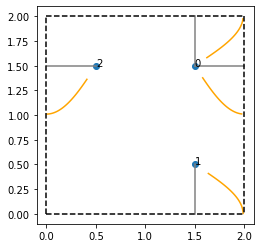

In [11]:
# now load the graph state and plot it
new_graph = Graph.load_graph_state(file_name='example_graph')
new_graph.plot('node_id')

# 2. Training an agent
We now move to training a RL agent, that has access to the actions above and is then able to choose the best possible subgraph at each node position. Note that for the purpose of this tutorial, the number of training episodes is chosen to be very low meaning that this will most probably not lead to a very good policy.

prefill replay memory
start training
 new max record arrange grid:  3.6219006071525643
 new max record arrange grid:  3.6219007636530347
 new max record arrange grid:  4.708470773648287
   10 mean training reward:  3.59
done


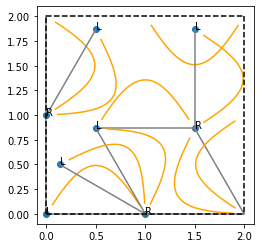

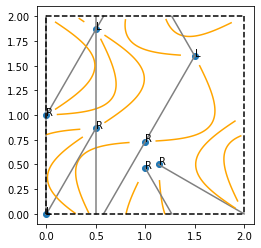

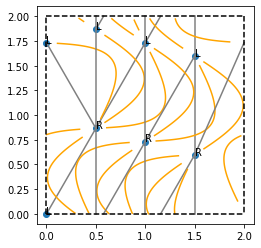

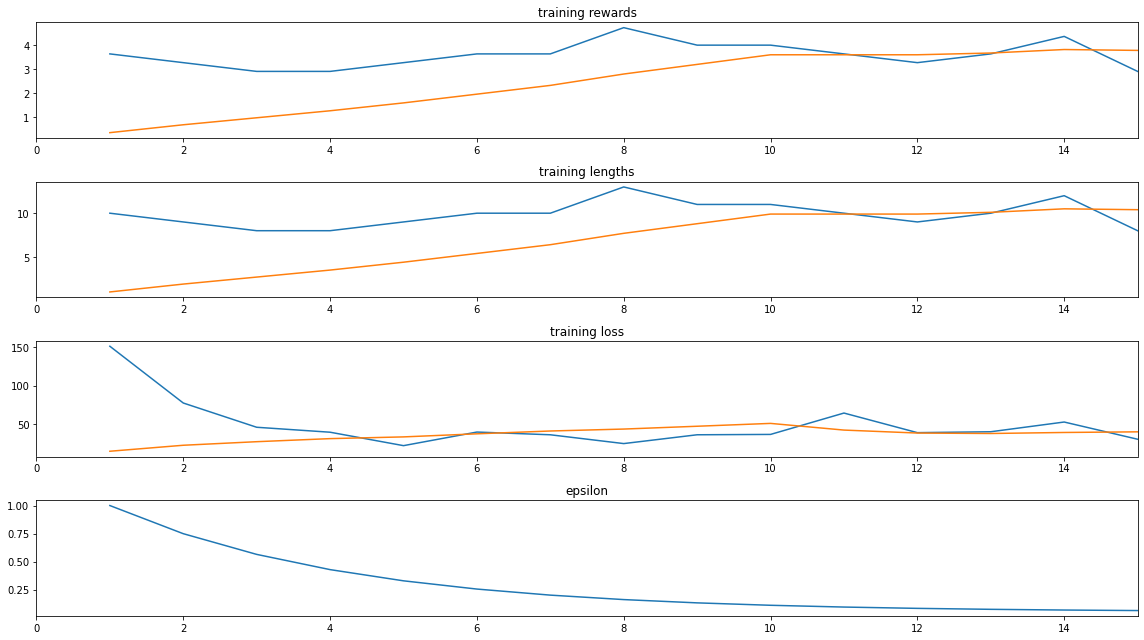

[3.6219006071525643, 3.6219006071525643, 3.6219007636530347, 3.6219007636530347, 4.708470773648287, 4.708470773648287]
[1, 6, 6, 8, 8, 15]


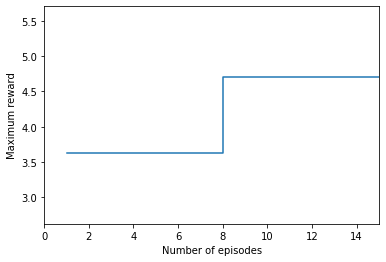

In [5]:
import numpy as np
from metabatt.reinforce.environments import MetabattEnvSubgraphs
from metabatt.reinforce.agents import QAgentReplayMemory
# we start from scratch here
subgraphs = Subgraphs(angles=[0, 30, 60, 90, 120, 150, 180],
                      lengths=[1])

# create the environment
env = MetabattEnvSubgraphs(n_cells_x=3,
                           n_cells_y=3,
                           subgraphs=subgraphs)

NUM_EPISODES = 15 #500  # this is very little, trained agent uses 500
# create an agent and set hyperparameters
agent = QAgentReplayMemory(env=env,
                          n_inputs=16, # this is the state representation
                          n_outputs=env.action_space.n,
                          max_epsilon=1.0,
                          min_epsilon=0.05,
                          gamma=0.99,  # discounted reward
                          tau=0.01, # target network update rate
                          batch_size=8,  # Experience replay, trained agent uses 64
                          lambda_=-np.log(0.01)/NUM_EPISODES,  # decay for epsilon-greedy
                          replay_memory_capacity=16,  # trained agent uses 1000
                          learning_rate=0.0005,
                          prefill_memory=True,
                          random_actions=False,  # random agent
                          save_best_graph=True)  # save the highest ranking graph state

# train the agent
agent.train(num_episodes=NUM_EPISODES)  # also plots results when finished

The agent just plotted every new top ranking graph during the training stage. Sine we chose to save the best graph state, we can now visualize it.

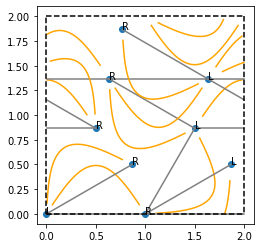

In [13]:
best_graph = Graph.load_graph_state('best_graph')
best_graph.plot()

## 2.1. Saving training hyperparameters
While full reproducibility can't be achieved due the randomness of the training process, we can still save all parameters used to train the agent. These hyperparameters together with the trained weights should be enough to be able to compare different runs.

In [14]:
# save model parameters
agent.save_hyperparameters(fname='hyperparams')

In [15]:
agent_reproduce = QAgentReplayMemory.from_hyperparameters(fname='hyperparams')
# now we can run exactly the same as above
# Just uncomment if you want to do that

#agent_reproduce.train(**agent_reproduce.hyper_dic['train'])

Note that the full hyperparameters dictionary is stored in `agent.hyper_dic` .

## 3. Saving trained agents and loading pretrained agents
Once a good agent is found, its nice to save the weights to use it for prediction tasks.

In [16]:
# for saving the state of the model simply do
agent.save_model(agent.policy_dqn, file_name='my_awesome_model_weights')

Lets now move towards loading a pretrained agent. Luckily, there is one pretrained model in this repository that we can use and check its performance.

---- start prediction using pretrained model -----
 new max record arrange grid:  3.9840910278189035
 new max record arrange grid:  4.708470930148757
 new max record arrange grid:  4.708470930148758
   10 mean prediction reward:  3.88
 new max record arrange grid:  4.708471086649228
 new max record arrange grid:  5.070661194314625
 new max record arrange grid:  5.795041096644479
   20 mean prediction reward:  4.20
---------------------- done ----------------------


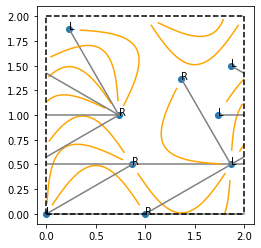

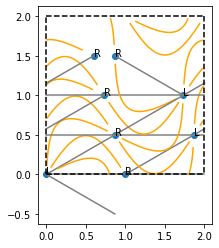

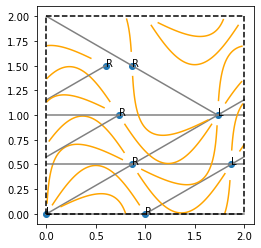

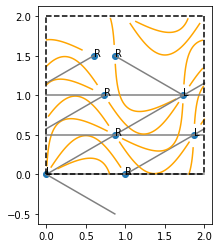

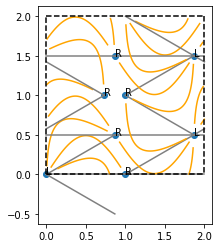

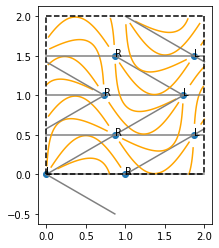

(array([4., 8., 8., 5., 0., 3., 4., 2., 0., 1.]),
 array([2.8975207 , 3.18727274, 3.47702478, 3.76677682, 4.05652886,
        4.3462809 , 4.63603294, 4.92578498, 5.21553702, 5.50528906,
        5.7950411 ]),
 <BarContainer object of 10 artists>)

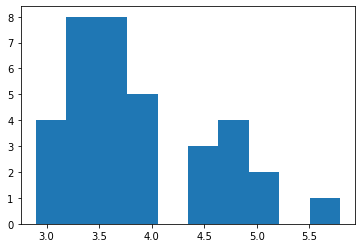

In [6]:
import metabatt
import matplotlib.pyplot as plt

# make sure you have the correct path to the pretrained model which can be found in the test folder of the repository
file_name = 'pretrained_16_16'
path_to_model = './../tests/pretrained_models/' + file_name
# we need to get a model to load the weights into, all this is done when calling load_model
best_model = agent.load_model(file_name=path_to_model)

# now use that model to make predictions
# note that even though epsilon is 0, the node selection is still random!
agent.predict(model=best_model, num_episodes=20, epsilon=0, save_best_graph=True)
plt.show()
plt.hist(agent.rewards)

Fantastic, hopefully better than the version above. Note that the environment is in fact still random since `select_focal_node` is done randomly and therefore produces different results although epsilon is set to zero.

We can also use the agent to run on a different system size/cell. The only constraint is that the state representation cannot change.

---- start prediction using pretrained model -----
 new max record arrange grid:  3.380440726653985
 new max record arrange grid:  3.541414107838607
 new max record arrange grid:  3.7023876281347565
 new max record arrange grid:  4.185307702132857
   10 mean prediction reward:  3.59
---------------------- done ----------------------


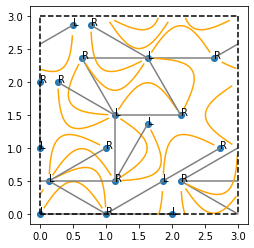

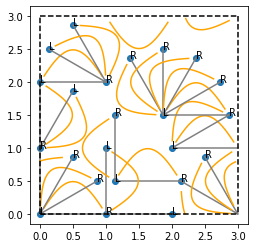

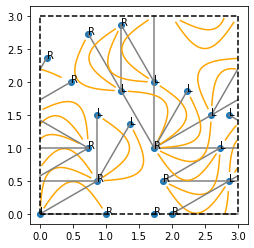

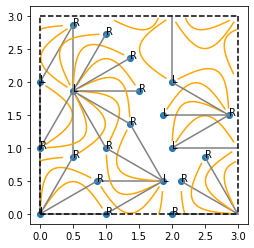

(array([ 3.,  9., 15.,  8.,  1.,  6.,  2.,  0.,  0.,  1.]),
 array([2.89752055, 3.18727257, 3.4770246 , 3.76677662, 4.05652864,
        4.34628067, 4.63603269, 4.92578471, 5.21553674, 5.50528876,
        5.79504078]),
 <BarContainer object of 10 artists>)

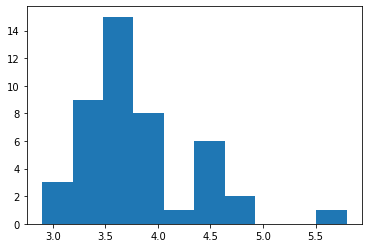

In [18]:
import metabatt
import matplotlib.pyplot as plt

# create the environment
env = MetabattEnvSubgraphs(n_cells_x=4,
                           n_cells_y=4,
                           subgraphs=subgraphs)

# now use the new environment together with the pretrained agent
agent.env = env
agent.predict(model=best_model, num_episodes=10, epsilon=0, save_best_graph=True)
plt.show()
plt.hist(agent.rewards)

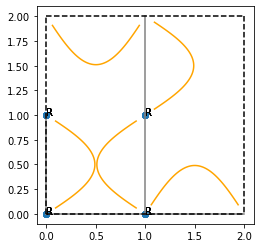

In [8]:
# Grid pattern

grid_graph = Graph(n_cells_w=3,  # dimension width
              n_cells_h=3,  # dimension height
              max_edge_length=1.5, # reduces computational time if known
              pbc=[True, True]) # apply periodic boundary conditions

grid_graph.add_node(node_id=0, position=[0, 0])
grid_graph.add_node(node_id=1, position=[0, 1])
grid_graph.add_node(node_id=2, position=[1, 0])
grid_graph.add_node(node_id=3, position=[1, 1])

grid_graph.add_edge(Edge(grid_graph.get_node(0), grid_graph.get_node(1), grid_graph))
# grid_graph.add_edge(Edge(grid_graph.get_node(1), grid_graph.get_node(0), grid_graph))

grid_graph.add_edge(Edge(grid_graph.get_node(0), grid_graph.get_node(2), grid_graph))
grid_graph.add_edge(Edge(grid_graph.get_node(2), grid_graph.get_node(0), grid_graph))

# grid_graph.add_edge(Edge(grid_graph.get_node(1), grid_graph.get_node(3), grid_graph))
# grid_graph.add_edge(Edge(grid_graph.get_node(3), grid_graph.get_node(1), grid_graph))

grid_graph.add_edge(Edge(grid_graph.get_node(2), grid_graph.get_node(3), grid_graph))
grid_graph.add_edge(Edge(grid_graph.get_node(3), grid_graph.get_node(2), grid_graph))


grid_graph.assign_rotation_to_nodes()  # rotation direction needs to be known, can also be set by hand
grid_graph.bend_edges()

grid_angles=[0, 90]
lengths=[1]
grid_subgraphs = Subgraphs(grid_angles, lengths)
# grid_subgraphs.visualize()

# grid_graph.add_subgraph_to_node(grid_graph.get_node(0), grid_subgraphs.graphs[1])
# grid_graph.add_subgraph_to_node(grid_graph.get_node(1), grid_subgraphs.graphs[0])

# grid_graph.add_subgraph_to_node(grid_graph.get_node(0), grid_subgraphs.graphs[0])
# grid_graph.add_subgraph_to_node(grid_graph.get_node(2), grid_subgraphs.graphs[1])

# grid_graph.add_subgraph_to_node(grid_graph.get_node(1), grid_subgraphs.graphs[1])

# grid_graph.add_subgraph_to_node(grid_graph.get_node(2), grid_subgraphs.graphs[0])

grid_graph.plot()